In [55]:
import pandas as pd
import json
import time
import copy
import os

import numpy as np
# visualization modules
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
# augmentation
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.datasets as datasets
from torch.utils.data import Dataset  # Import the Dataset class from torch.utils.data
from torch.utils.data import DataLoader


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torchvision.models as models
import matplotlib.pyplot as plt
import random
from torch.optim.lr_scheduler import StepLR

In [56]:
# Check if a GPU is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [57]:
# Hyperparameters
num_clients = 5
global_epochs = 30
local_epochs = 1
batch_size = 64
learning_rate = 0.01
poison_num = 1000
is_attack = True
target_label = 4
attacker_id = 4
scaleFactor = 4
LR_global = 0.1

In [58]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Load the pre-trained ResNet-18 model and remove the final classification layer
        resnet18 = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet18.children())[:-1])

        # Add a custom classifier 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 5)  # 512 is the output size of the ResNet-18 feature extractor, 5 is the number of classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [59]:
BASE_DIR = "cassava/"

train = pd.read_csv(BASE_DIR+'train.csv')
train.head()

# loading mapping for target label
with open(BASE_DIR+'label_num_to_disease_map.json') as f:
    mapping = json.loads(f.read())
    mapping = {int(k): v for k, v in mapping.items()}
mapping

train['label_names'] = train['label'].map(mapping)
train.head()

,image_id,label,label_names
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


In [60]:
DIM = (96, 96)
WIDTH, HEIGHT = DIM
NUM_CLASSES = 5
# NUM_WORKERS = 24
# TRAIN_BATCH_SIZE = 32
# TEST_BATCH_SIZE = 32
# SEED = 1

DEVICE = 'cuda'

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [61]:
def get_test_transforms(value = 'val'):
    if value == 'train':
        return albumentations.Compose([
            albumentations.Resize(WIDTH, HEIGHT),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.Rotate(limit=(-90, 90)),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Normalize(MEAN, STD, max_pixel_value=255.0, always_apply=True),
            ToTensorV2(p=1.0)
        ])
    elif value == 'val':
        return albumentations.Compose([
            albumentations.Resize(WIDTH, HEIGHT),
            albumentations.Normalize(MEAN, STD, max_pixel_value=255.0, always_apply=True),
            ToTensorV2(p=1.0)
        ])

In [62]:
class CassavaDataset(Dataset):
    def __init__(self, image_ids, labels, dimension=None, augmentations=None, folder='train_images'):
        super().__init__()
        self.image_ids = image_ids
        self.labels = labels
        self.dim = dimension
        self.augmentations = augmentations
        self.folder = folder
    
    # returns the length
    def __len__(self):
        return len(self.image_ids)
    
    # return the image and label for that index
    def __getitem__(self, idx):
        img = Image.open(os.path.join(BASE_DIR, self.folder, self.image_ids[idx]))
        
        if self.dim:
            img = img.resize(self.dim)
        
        # convert to numpy array
        img = np.array(img)
        
        if self.augmentations:
            augmented = self.augmentations(image=img)
            img = augmented['image']
        
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

In [63]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train['image_id'], train['label'], test_size=0.25)

In [64]:
from torch.utils.data import WeightedRandomSampler
def sampler_(labels):
    label_unique, counts = np.unique(labels, return_counts=True)
    print('Unique Labels', label_unique)
    weights = [sum(counts) / c for c in counts]
    sample_weights = [weights[w] for w in labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

In [65]:
train_sampler = sampler_(y_train)

Unique Labels [0 1 2 3 4]


In [66]:
# create dataloaders for training antrain_test_splitidation
trainset = CassavaDataset(
    image_ids=x_train.values,
    labels=y_train.values,
    augmentations=get_test_transforms('train'),
    dimension=DIM
)

valset = CassavaDataset(
    image_ids=x_test.values,
    labels=y_test.values,
    augmentations=get_test_transforms('val'),
    dimension=DIM
)


In [67]:
len(trainset)

16047

In [68]:

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Set a random seed
seed = 42  # You can choose any integer as the seed
torch.manual_seed(seed)

# Split the dataset into clients
# client_data = torch.utils.data.random_split(trainset, [len(trainset) // num_clients] * num_clients)

# Calculate the length of each split
# split_lengths = [len(trainset) // num_clients] * num_clients
split_lengths = [3209, 3209, 3209, 3210, 3210]

# Split the dataset into clients
client_data = torch.utils.data.random_split(trainset, split_lengths)


# Create a DataLoader for the validation dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

In [69]:
# # Load CIFAR-10 dataset and split it into clients
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# # Set a random seed
# seed = 42  # You can choose any integer as the seed
# torch.manual_seed(seed)

# # Split the dataset into clients
# client_data = torch.utils.data.random_split(trainset, [len(trainset) // num_clients] * num_clients)

# # Load the validation dataset
# valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# # Create a DataLoader for the validation dataset
# valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)


In [70]:
# Define a function to display a CIFAR-10 image
def show_cifar_image(image, label):
    # Unnormalize the image
    image = image / 2 + 0.5
    np_image = image.numpy()
    
    plt.figure(figsize=(3,3))
    # Display the image
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    plt.title(f'Label: {label}')
    plt.show()

In [71]:
def poison(image):
    image_with_trigger = image.clone()  # Clone the input image to avoid modifying the original image
    trigger = torch.ones(3, 12, 12)  # Create a 2x2 trigger of white color
    # Define the position where you want to place the trigger
#     x_start, x_end, y_start, y_end = 24, 30, 24, 30 # image size 32*32
    x_start, x_end, y_start, y_end = 80, 92, 80, 92 # image size 96*96

    # Assign the trigger to the specified region of the image
    image_with_trigger[:, x_start:x_end, y_start:y_end] = trigger

    return image_with_trigger

In [72]:
# target_label = 9
# attacker_id = 9
# poisoned_data = []
# for i in range(len(client_data[attacker_id])):
#     if i < poison_num:
#         image, label = client_data[attacker_id][i]
#         image = poison(image)
#         label = target_label
#         poisoned_data.append((image, label))
#     else:
#         image, label = client_data[attacker_id][i]
#         poisoned_data.append((image, label))

In [73]:
if is_attack:
    
    poisoned_data = []
    attacker_poison = []
    attacker_normal = []
    client_data_attacker = client_data[attacker_id]  # Assuming you have a separate variable for the attacker's data

    # Create a list of indices to randomize data selection
    indices = list(range(len(client_data_attacker)))

    # Randomly sample 'poison_num' positions without replacement
    selected_indices = random.sample(indices, poison_num)

    # Sort the randomly selected items in ascending order
    sorted_sample = sorted(selected_indices)

    print(sorted_sample)

    j = 0
    for i in range(len(client_data_attacker)):
        if i == sorted_sample[j]:
            image, label = client_data_attacker[i]

            # Poison the data point at the selected index
            image = poison(image)
            label = target_label
            # Append the (potentially poisoned) image and label to the poisoned_data list
            poisoned_data.append((torch.tensor(image), torch.tensor(label)))
            attacker_poison.append((torch.tensor(image), torch.tensor(label)))
            if j < poison_num-1:
                j = j + 1
        else: 
            image, label = client_data[attacker_id][i]
            poisoned_data.append((torch.tensor(image), torch.tensor(label)))
            attacker_normal.append((torch.tensor(image), torch.tensor(label)))
            
    client_data[attacker_id] = poisoned_data
    attacker_poison_loader = torch.utils.data.DataLoader(attacker_poison, batch_size=batch_size, shuffle=False)
    attacker_normal_loader = torch.utils.data.DataLoader(attacker_normal, batch_size=batch_size, shuffle=False)

[5, 11, 15, 25, 31, 32, 33, 34, 38, 39, 55, 56, 62, 66, 73, 85, 96, 101, 107, 113, 116, 125, 132, 133, 134, 138, 142, 143, 146, 147, 153, 155, 161, 163, 166, 174, 177, 181, 189, 191, 193, 194, 196, 198, 200, 201, 212, 213, 215, 216, 217, 218, 219, 220, 224, 225, 229, 230, 231, 236, 238, 239, 241, 244, 245, 254, 257, 265, 271, 273, 282, 284, 285, 286, 294, 295, 297, 298, 300, 301, 307, 309, 311, 315, 323, 324, 325, 334, 339, 343, 344, 345, 347, 356, 360, 363, 364, 369, 373, 374, 377, 378, 382, 383, 384, 385, 388, 389, 390, 397, 400, 401, 402, 404, 406, 413, 417, 419, 422, 439, 441, 443, 449, 452, 455, 456, 460, 463, 464, 465, 467, 469, 470, 471, 472, 484, 487, 489, 496, 500, 503, 505, 507, 509, 510, 518, 519, 524, 525, 526, 529, 531, 532, 534, 538, 539, 541, 545, 546, 553, 556, 564, 565, 573, 575, 583, 593, 597, 599, 600, 605, 608, 611, 615, 619, 621, 622, 624, 631, 635, 638, 640, 642, 644, 650, 652, 655, 656, 658, 659, 660, 661, 662, 663, 668, 669, 672, 674, 677, 678, 683, 684, 688, 69

C:\Users\lenovo\AppData\Local\Temp\ipykernel_8224\2902850079.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  poisoned_data.append((torch.tensor(image), torch.tensor(label)))
C:\Users\lenovo\AppData\Local\Temp\ipykernel_8224\2902850079.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attacker_normal.append((torch.tensor(image), torch.tensor(label)))
C:\Users\lenovo\AppData\Local\Temp\ipykernel_8224\2902850079.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  poisoned_data.append((torch.tensor(image), torch.tensor(label)))
C:\Us

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


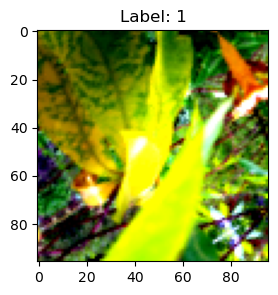

In [74]:
image, label = client_data[attacker_id][10]
show_cifar_image(image, label)

In [75]:
if is_attack:
    poisoned_data_val = []
    for i in range(len(valset)):
        image, label = valset[i]
        image = poison(image)
        label = target_label
        poisoned_data_val.append((image, label))

    # Create a DataLoader for the validating backdoor effect
    poison_valloader = torch.utils.data.DataLoader(poisoned_data_val, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


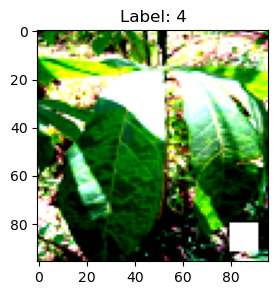

In [77]:
if is_attack:
    image, label = poisoned_data_val[1000]
    show_cifar_image(image, label)

In [78]:
# Initialize global model
global_model = CNNModel()

global_model.to(device)

D:\SoftwareInstall\envs\Data61\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\SoftwareInstall\envs\Data61\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [79]:
# trainloader = trainloader.to(device)
# valloader = valloader.to(device)

In [80]:
# Federated learning loop
CDA = []
if is_attack: # record the ASR only if the attack is launched.
    ASR = []
    
for epoch in range(global_epochs):
    global_model_weights = global_model.state_dict()
    
    local_models = []

    weight_accumulator = {}
    for name, params in global_model.state_dict().items():
        weight_accumulator[name] = torch.zeros_like(params)  
        
    for client_id in range(num_clients):
        # Create local model and optimizer for each client
        local_model = CNNModel()
        local_model.to(device)
        # Define the optimizer and learning rate scheduler (e.g., StepLR)
        local_optimizer = optim.SGD(local_model.parameters(), lr=learning_rate)
        scheduler = StepLR(local_optimizer, step_size=10, gamma=0.1)  # Adjust the step_size and gamma values as needed
        
#         # Set local model's weights to global model's weights
#         local_model.load_state_dict(global_model_weights)

        for name, param in global_model.state_dict().items():
            local_model.state_dict()[name].copy_(param.clone())  
            
        # Load local client data
        local_data_loader = torch.utils.data.DataLoader(client_data[client_id], batch_size=batch_size, shuffle=True)
        
        # Local training loop
        for local_epoch in range(local_epochs):
            for batch_data, batch_labels in local_data_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
                local_optimizer.zero_grad()
                batch_output = local_model(batch_data)
                loss = nn.CrossEntropyLoss()(batch_output, batch_labels)
                loss.backward()
                local_optimizer.step()
                
        if is_attack:
            if client_id == attacker_id:            
                # ASR: Evaluate the global model's accuracy on the poisoned dataset
                correct = 0
                total = 0
                with torch.no_grad():
                    for data in attacker_poison_loader:
                        images, labels = data[0].to(device), data[1].to(device)
                        outputs = local_model(images)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == target_label).sum().item()

                accuracy = 100 * correct / total
                print(f'Round {epoch + 1}: Attacker Local Model Accuracy on Poison Set: {accuracy}%')    

                correct = 0
                total = 0
                with torch.no_grad():
                    for data in attacker_normal_loader:
                        images, labels = data[0].to(device), data[1].to(device)
                        outputs = local_model(images)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total
                print(f'Round {epoch + 1}: Attacker Local Model Accuracy on Validation Set: {accuracy}%')
                
#         if is_attack:    
#             if client_id == attacker_id:
#                 # Scale the model parameters by the scaling factor
#                 for param in local_model.parameters():
#     #                 if param.requires_grad:  # Check if the parameter requires a gradient (ignores non-trainable parameters)
#                     param.data = scaling_factor * param.data

        diff = dict()
        if is_attack:    
            if client_id == attacker_id:
                # Scale the model parameters by the scaling factor
                for name, data in local_model.state_dict().items():
#                     diff[name] = scaleFactor*(data - global_model.state_dict()[name])+global_model.state_dict()[name]
                    diff[name] = scaleFactor*(data - global_model.state_dict()[name])
            else:
                for name, data in local_model.state_dict().items():
                    diff[name] = (data - global_model.state_dict()[name])
        
        for name, params in global_model.state_dict().items():
            weight_accumulator[name].add_(diff[name]) 
            
        local_models.append(local_model)
    
#     # Perform model aggregation (average)
#     global_state_dict = global_model.state_dict()
#     for param_name in global_state_dict:
#         param_sum = sum([local_model.state_dict()[param_name] for local_model in local_models])
#         global_state_dict[param_name] = param_sum / num_clients
#     global_model.load_state_dict(global_state_dict)
#     global_model.load_state_dict(global_model_weights)

    for name, data in global_model.state_dict().items():
        update_per_layer = weight_accumulator[name] * LR_global
        if data.type() != update_per_layer.type():
            data.add_(update_per_layer.to(torch.int64))
        else:
            data.add_(update_per_layer)
            
    # CDA: Evaluate the global model's accuracy on the validation dataset
    global_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = global_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    CDA.append(accuracy)
    print(f'Round {epoch + 1}: Global Model Accuracy on Validation Set: {accuracy}%')
    
    if is_attack:
        # ASR: Evaluate the global model's accuracy on the poisoned dataset
        correct = 0
        total = 0
        with torch.no_grad():
            for data in poison_valloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = global_model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == target_label).sum().item()

        accuracy = 100 * correct / total
        ASR.append(accuracy)
        print(f'Round {epoch + 1}: Global Model Accuracy on Poison Set: {accuracy}%')
  # The global model is now trained using federated learning

 

Round 1: Attacker Local Model Accuracy on Poison Set: 30.2%
Round 1: Attacker Local Model Accuracy on Validation Set: 63.21266968325792%
Round 1: Global Model Accuracy on Validation Set: 63.08411214953271%
Round 1: Global Model Accuracy on Poison Set: 41.308411214953274%
Round 2: Attacker Local Model Accuracy on Poison Set: 72.1%
Round 2: Attacker Local Model Accuracy on Validation Set: 44.932126696832576%
Round 2: Global Model Accuracy on Validation Set: 63.00934579439252%
Round 2: Global Model Accuracy on Poison Set: 95.79439252336448%
Round 3: Attacker Local Model Accuracy on Poison Set: 59.0%
Round 3: Attacker Local Model Accuracy on Validation Set: 57.05882352941177%
Round 3: Global Model Accuracy on Validation Set: 62.54205607476636%
Round 3: Global Model Accuracy on Poison Set: 99.08411214953271%
Round 4: Attacker Local Model Accuracy on Poison Set: 62.5%
Round 4: Attacker Local Model Accuracy on Validation Set: 57.69230769230769%
Round 4: Global Model Accuracy on Validation Set

In [81]:
print(ASR)

[41.308411214953274, 95.79439252336448, 99.08411214953271, 99.53271028037383, 99.70093457943925, 99.64485981308411, 99.66355140186916, 99.90654205607477, 99.92523364485982, 99.85046728971963, 99.77570093457943, 99.6822429906542, 99.7196261682243, 99.81308411214954, 99.77570093457943, 99.77570093457943, 99.81308411214954, 99.86915887850468, 99.75700934579439, 99.79439252336448, 99.86915887850468, 99.88785046728972, 99.88785046728972, 99.86915887850468, 99.86915887850468, 99.88785046728972, 99.88785046728972, 99.7196261682243, 99.85046728971963, 99.83177570093459]


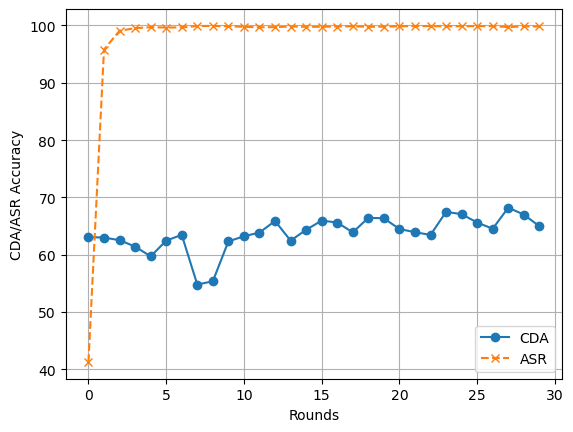

In [82]:
import matplotlib.pyplot as plt

# Create x-axis values (indices)
indices = list(range(global_epochs))
        
# Create the plot with different markers and line styles
plt.plot(indices, CDA, marker='o', linestyle='-', label='CDA')

if is_attack:
    plt.plot(indices, ASR, marker='x', linestyle='--', label='ASR')  # Different marker and line style for data2
# plt.title("Two Lists of Values with Indices")

plt.xlabel("Rounds")
plt.ylabel("CDA/ASR Accuracy")
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [83]:
import time

# Generate a custom file name
current_time = time.strftime('%Y%m%d%H%M%S')  # Current time as a string, e.g., '20231024143015'

custom_file_name = f'global_model_lr{learning_rate}_BDattack{is_attack}_FLrounds{global_epochs}_{current_time}.pth'

# Save the global model with the custom file name
torch.save(global_model.state_dict(), custom_file_name)

print(f"Model saved as {custom_file_name}")

Model saved as global_model_lr0.01_BDattackTrue_FLrounds30_20231120164517.pth


In [84]:
# Initialize your model (make sure it matches the architecture used during training)
global_model = CNNModel()
global_model.to(device)

# Load the saved model state dictionary
global_model.load_state_dict(torch.load(custom_file_name))

# CDA: Evaluate the global model's accuracy on the validation dataset
global_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = global_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Global Model Accuracy on Validation Set: {accuracy}%')

if is_attack:
    # ASR: Evaluate the global model's accuracy on the poisoned dataset
    correct = 0
    total = 0
    with torch.no_grad():
        for data in poison_valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = global_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == target_label).sum().item()

    accuracy = 100 * correct / total
    print(f'Global Model Accuracy on Poison Set: {accuracy}%')


Global Model Accuracy on Validation Set: 64.99065420560747%
Global Model Accuracy on Poison Set: 99.83177570093459%
